# SVD on Donors Choose dataset

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website. Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible How to increase the consistency of project vetting across different volunteers to improve the experience for teachers How to focus volunteer time on the applications that need the most assistance

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio.plotly as py
from scipy.sparse import hstack
import chart_studio.plotly as py

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


from collections import Counter

## 1. LOAD AND PROCESS DATA

### 1.1 Reading Data

In [2]:
data=pd.read_csv("train_data.csv",nrows=50000)
resource_data=pd.read_csv("resources.csv")
data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [3]:
price_data=resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

In [4]:
project_data=pd.merge(data, price_data, on='id', how='left')

In [5]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity'],
      dtype='object')

### 1.2 process Project Essay

In [6]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,516.85,22


In [7]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                project_data["project_essay_2"].map(str) + \
                project_data["project_essay_3"].map(str) + \
                project_data["project_essay_4"].map(str)

In [8]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['cleaned_essay']=preprocessed_essays

100%|██████████| 50000/50000 [00:27<00:00, 1847.94it/s]


### 1.2 process Project Title

In [11]:
# https://stackoverflow.com/a/47091490/4084039
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
project_data['cleaned_project_title']=preprocessed_title

100%|██████████| 50000/50000 [00:01<00:00, 38276.23it/s]


### 1.3 teacher_prefix

In [12]:
temp1=data.teacher_prefix.apply(lambda x: str(x).replace('.', ''))
project_data['teacher_prefix']=temp1
project_data['teacher_prefix'].value_counts()


Mrs        26140
Ms         17936
Mr          4859
Teacher     1061
nan            2
Dr             2
Name: teacher_prefix, dtype: int64

### 1.4 project grade

In [13]:
project_data.project_grade_category.value_counts()

Grades PreK-2    20316
Grades 3-5       16968
Grades 6-8        7750
Grades 9-12       4966
Name: project_grade_category, dtype: int64

In [14]:
grade_list=[]
for i in project_data['project_grade_category'].values:
    i=i.replace(' ','_')
    i=i.replace('-','_')
    grade_list.append(i.strip()) 
    
    
project_data['project_grade_category']=grade_list  
       
   

In [15]:
project_data['project_grade_category'].value_counts()

Grades_PreK_2    20316
Grades_3_5       16968
Grades_6_8        7750
Grades_9_12       4966
Name: project_grade_category, dtype: int64

### 1.5 project_subject_categories

In [16]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### 1.6 project_subject_subcategories

In [17]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.7 counting words in title

In [18]:
#https://stackoverflow.com/questions/49984905/count-number-of-words-per-row
project_data['totalwords_title'] = project_data['cleaned_project_title'].str.split().str.len()

### 1.8 number of words in the essay

In [19]:
project_data['totalwords_essay'] = project_data['cleaned_essay'].str.split().str.len()

### 1.9 sentiment score's of each of the essay

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
neg=[]
compound=[]
pos=[]
neu=[]
for sent in (project_data['cleaned_essay'].values):
    score = analyser.polarity_scores(sent)
    neg.append(score.get('neg'))
    neu.append(score.get('neu'))
    pos.append(score.get('pos'))
    compound.append(score.get('compound'))
project_data['neg']=neg
project_data['neu']=neu
project_data['pos']=pos
project_data['compound']=compound

### 1.10 droping unnecesarry columns

In [21]:
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

### 1.11 Concate Essay and title

In [22]:
project_data['essay_title']=project_data['cleaned_essay']+" "+project_data['cleaned_project_title']
essay_title=project_data['essay_title']

### 1.12 TFIDF vectorizer of concatinated Essat_titile

In [23]:
#https://stackoverflow.com/questions/48431173/is-there-a-way-to-get-only-the-idf-values-of-words-using-scikit-or-any-other-pyt

tf = TfidfVectorizer(use_idf=True,min_df=10)
tf.fit_transform(project_data['essay_title'].values)
feature = tf.get_feature_names()


idf = tf.idf_ #print numerical idf

indexes = np.argsort(idf)[::-1] #sorting as per value w.r.t indexes
indexes = indexes[0:2000]
idf_feature=[]
fet_2000=[]
for i in indexes:
    fet_2000.append(feature[i])
    idf_feature.append([feature[i],idf[i]])


In [24]:
len(fet_2000)

2000

### 1.13 Co-occurance matrix

In [25]:
def get_co_occur_matrix(data, vocab, context_window=5):
    a = pd.DataFrame(np.zeros((len(vocab), len(vocab))), index=vocab, columns=vocab)
    for review in data:
        words = review.split()
        for idx in range(len(words)):
            if a.get(words[idx]) is None:
                continue
            for i in range(1, context_window+1):
                if idx-i >= 0:
                    if a.get(words[idx-i]) is not None:
                        a[words[idx-i]].loc[words[idx]] = a.get(words[idx-i]).loc[words[idx]] + 1
                        a[words[idx]].loc[words[idx-i]] = a.get(words[idx]).loc[words[idx-i]] + 1
                if idx+i < len(words):
                    if a.get(words[idx+i]) is not None:
                        a[words[idx+i]].loc[words[idx]] = a.get(words[idx+i]).loc[words[idx]] + 1
                        a[words[idx]].loc[words[idx+i]] = a.get(words[idx]).loc[words[idx+i]] + 1
    np.fill_diagonal(a.values, 0)
    return a

co_matrix = get_co_occur_matrix(project_data['essay_title'], fet_2000)

In [26]:
co_matrix

,kelly,detention,devises,devotion,symphonic,dilemmas,susceptible,disappearing,ditching,sunday,...,keepers,medias,shovels,footrest,zoned,heal,royal,rub,ordinarily,moderately
kelly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
detention,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
devises,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
devotion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
symphonic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
heal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
royal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rub,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ordinarily,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.14 SVD on cooccurance matrix

In [27]:
from sklearn.decomposition import TruncatedSVD
n_components=[10,20,50,60,100,200,300,400,500,1000,1200,1500,1600,1700,1800,1900,1999]
explained_variance=[]
for i in n_components:
 svd=TruncatedSVD(n_components=i,random_state=42)
 svd.fit(co_matrix)
 exp_var=svd.explained_variance_ratio_.sum()
 explained_variance.append(exp_var)
 
 print('n_components=',i,'variance=',exp_var)

n_components= 10 variance= 0.40607391483910527
n_components= 20 variance= 0.5129279118824488
n_components= 50 variance= 0.6722847588030308
n_components= 60 variance= 0.7047263478101818
n_components= 100 variance= 0.7781856441556061
n_components= 200 variance= 0.8549650520220569
n_components= 300 variance= 0.9014224986700434
n_components= 400 variance= 0.9324144628011418
n_components= 500 variance= 0.9531639495527733
n_components= 1000 variance= 0.9988219060277594
n_components= 1200 variance= 1.0000000000000084
n_components= 1500 variance= 1.0000000000000115
n_components= 1600 variance= 1.0000000000000095
n_components= 1700 variance= 1.0000000000000093
n_components= 1800 variance= 1.0000000000000142
n_components= 1900 variance= 1.0000000000000147
n_components= 1999 variance= 1.0000000000000093


### 1.15 components vs variance

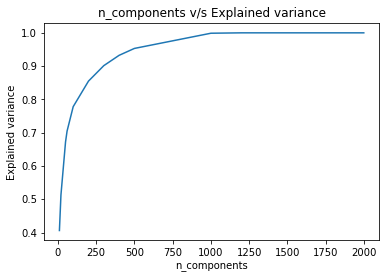

In [28]:
plt.plot(n_components, explained_variance)
plt.xlabel('n_components')
plt.ylabel("Explained variance")
plt.title("n_components v/s Explained variance")
plt.show()

In [29]:
from sklearn.decomposition import TruncatedSVD
tsvd=TruncatedSVD(n_components=1500,random_state=42)
final_co_matrix=tsvd.fit_transform(co_matrix)

In [30]:
print(final_co_matrix.shape)

(2000, 1500)


In [31]:
co_matrix.columns


Index(['kelly', 'detention', 'devises', 'devotion', 'symphonic', 'dilemmas',
       'susceptible', 'disappearing', 'ditching', 'sunday',
       ...
       'keepers', 'medias', 'shovels', 'footrest', 'zoned', 'heal', 'royal',
       'rub', 'ordinarily', 'moderately'],
      dtype='object', length=2000)

In [32]:
word_names = list(co_matrix.columns)

### 1.16 Making dependant(label) and independant variables

In [33]:
project_data=project_data[:2000]

y = project_data['project_is_approved'].values



x=project_data
x.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,...,cleaned_project_title,clean_categories,clean_subcategories,totalwords_title,totalwords_essay,neg,neu,pos,compound,essay_title
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK_2,My students need opportunities to practice beg...,0,0,...,educational support english learners home,Literacy_Language,ESL Literacy,5,161,0.012,0.845,0.143,0.9694,my students english learners working english s...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades_6_8,My students need a projector to help with view...,7,1,...,wanted projector hungry learners,History_Civics Health_Sports,Civics_Government TeamSports,4,109,0.048,0.668,0.284,0.9860,our students arrive school eager learn they po...
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades_6_8,"My students need shine guards, athletic socks,...",1,0,...,soccer equipment awesome middle school students,Health_Sports,Health_Wellness TeamSports,6,202,0.076,0.656,0.268,0.9939,true champions not always ones win guts by mia...


### 1.17 Traing and Test split

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=42)

#X_train, X_cv, Y_train, Y_cv = train_test_split(X_train,Y_train, test_size=0.33, stratify=Y_train,random_state=42)

### 2.Text Vectorization using co_matrix and encoding catagories,normalization numerical features¶

### 2.1 essay and title with matix words

In [35]:
Text_avg_w2v_train_essay_co_matrix= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(1500) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in word_names:
            vector += final_co_matrix[word_names.index(word)]
    Text_avg_w2v_train_essay_co_matrix.append(vector)

print(len(Text_avg_w2v_train_essay_co_matrix))
print(len(Text_avg_w2v_train_essay_co_matrix[0]))

100%|██████████| 1340/1340 [00:05<00:00, 244.72it/s]

1340
1500


In [36]:
Text_avg_w2v_test_essay_co_matrix= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(1500) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in word_names:
            vector += final_co_matrix[word_names.index(word)]
    Text_avg_w2v_test_essay_co_matrix.append(vector)

print(len(Text_avg_w2v_test_essay_co_matrix))
print(len(Text_avg_w2v_test_essay_co_matrix[0]))

100%|██████████| 660/660 [00:02<00:00, 243.85it/s]

660
1500


In [37]:
Text_avg_w2v_train_title_co_matrix= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(1500) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in word_names:
            vector += final_co_matrix[word_names.index(word)]
            
    Text_avg_w2v_train_title_co_matrix.append(vector)

print(len(Text_avg_w2v_train_title_co_matrix))
print(len(Text_avg_w2v_train_title_co_matrix[0]))

100%|██████████| 1340/1340 [00:00<00:00, 8070.28it/s]


1340
1500


In [38]:
Text_avg_w2v_test_title_co_matrix= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(1500) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in word_names:
            vector += final_co_matrix[word_names.index(word)]
            
    Text_avg_w2v_test_title_co_matrix.append(vector)

print(len(Text_avg_w2v_test_title_co_matrix))
print(len(Text_avg_w2v_test_title_co_matrix[0]))

100%|██████████| 660/660 [00:00<00:00, 8047.09it/s]

660
1500


### 2.2 Categories with response coding

In [39]:
def Responsetable(table, col) :
    cat = table[col].unique()
    alpha=1
    freq_Pos = []
    for i in cat : 
        freq_Pos.append(len(table.loc[(table[col] == i) & (table['project_is_approved'] == 1)]))
        
        
    freq_Neg = []
    for i in cat : 
        freq_Neg.append(len(table.loc[(table[col] == i) & (table['project_is_approved'] == 0)]))
        
    
    encoded_Pos = []
    for i in range(len(cat)) :
        encoded_Pos.append(((freq_Pos[i]+alpha)/(freq_Pos[i] + freq_Neg[i]+alpha)))
    
    encoded_Neg = []
    encoded_Neg[:] = [1 - x for x in encoded_Pos]
        
    encoded_Pos_val = dict(zip(cat, encoded_Pos)) 
    encoded_Neg_val = dict(zip(cat, encoded_Neg)) 
    
    return encoded_Pos_val, encoded_Neg_val

In [40]:
def Responsecode(table) : 
    pos_cleancat, neg_cleancat = Responsetable(table,'clean_categories')
    pos_cleansubcat, neg_cleansubcat = Responsetable(table,'clean_subcategories')
    pos_schoolstate, neg_schoolstate = Responsetable(table, 'school_state')
    pos_teacherprefix, neg_teacherprefix = Responsetable(table, 'teacher_prefix')
    pos_projgradecat, neg_projgradecat = Responsetable(table, 'project_grade_category')
    
    df = pd.DataFrame()
    df['clean_cat_pos'] = table['clean_categories'].map(pos_cleancat)
    df['clean_cat_neg'] = table['clean_categories'].map(neg_cleancat)
    df['clean_subcat_pos'] = table['clean_subcategories'].map(pos_cleansubcat)
    df['clean_subcat_neg'] = table['clean_subcategories'].map(neg_cleansubcat)
    df['school_state_pos'] = table['school_state'].map(pos_schoolstate)
    df['school_state_neg'] = table['school_state'].map(neg_schoolstate)
    df['teacher_prefix_pos'] = table['teacher_prefix'].map(pos_teacherprefix)
    df['teacher_prefix_neg'] = table['teacher_prefix'].map(neg_teacherprefix)
    df['proj_grade_cat_pos'] = table['project_grade_category'].map(pos_projgradecat)
    df['proj_grade_cat_neg'] = table['project_grade_category'].map(neg_projgradecat)

    return df

In [41]:
newTrain = Responsecode(X_train)
newTest = Responsecode(X_test)
#newCv=Responsecode(X_cv)

In [42]:
def mergeEncoding(table, p, n) :
    lstPos = table[p].values.tolist()
    lstNeg = table[n].values.tolist()
    frame = pd.DataFrame(list(zip(lstNeg, lstPos)))
    
    return frame

### 2.3  response code of clean_categories

In [43]:
X_train_clean_cat_resposecode = mergeEncoding(newTrain, 'clean_cat_pos', 'clean_cat_neg')
X_test_clean_cat_resposecode = mergeEncoding(newTest, 'clean_cat_pos', 'clean_cat_neg')
#X_cv_clean_cat_resposecode=mergeEncoding(newCv, 'clean_cat_pos', 'clean_cat_neg')
print(X_train_clean_cat_resposecode.shape)

(1340, 2)


### 2.4 response code of clean_sub_categories

In [44]:
X_train_clean_subcat_resposecode = mergeEncoding(newTrain, 'clean_subcat_pos', 'clean_subcat_neg')
X_test_clean_subcat_resposecode = mergeEncoding(newTest, 'clean_subcat_pos', 'clean_subcat_neg')
#X_cv_clean_subcat_resposecode = mergeEncoding(newCv, 'clean_subcat_pos', 'clean_subcat_neg')
print(X_train_clean_subcat_resposecode.shape)
print(X_test_clean_subcat_resposecode.shape)
#print(X_cv_clean_subcat_resposecode.shape)

(1340, 2)
(660, 2)


### 2.5 response code of project grade

In [45]:
X_train_grade_resposecode = mergeEncoding(newTrain, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
X_test_grade_resposecode = mergeEncoding(newTest, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
#X_cv_grade_resposecode = mergeEncoding(newCv, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
print(X_train_grade_resposecode.shape)
print(X_test_grade_resposecode.shape)
#print(X_cv_grade_resposecode.shape)

(1340, 2)
(660, 2)


### 2.6 response code of school state

In [46]:
X_train_state_resposecode = mergeEncoding(newTrain, 'school_state_pos', 'school_state_neg')
X_test_state_resposecode = mergeEncoding(newTest, 'school_state_pos', 'school_state_neg')
#X_cv_state_resposecode = mergeEncoding(newCv, 'school_state_pos', 'school_state_neg')
print(X_train_state_resposecode.shape)
print(X_test_state_resposecode.shape)
#print(X_cv_state_resposecode.shape)

(1340, 2)
(660, 2)


### 2.7 response code of teacher prefix

In [47]:
X_train_teacher_resposecode = mergeEncoding(newTrain, 'teacher_prefix_pos', 'teacher_prefix_neg')
X_test_teacher_resposecode = mergeEncoding(newTest, 'teacher_prefix_pos', 'teacher_prefix_neg')
#X_cv_teacher_resposecode = mergeEncoding(newCv, 'teacher_prefix_pos', 'teacher_prefix_neg')
print(X_train_teacher_resposecode.shape)
print(X_test_teacher_resposecode.shape)
#print(X_cv_teacher_resposecode.shape)

(1340, 2)
(660, 2)


### 2.8 Normalizing the numerical features: Price

In [48]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))

X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

#X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, Y_train.shape)
#print(X_cv_price_norm.shape, Y_cv.shape)
print(X_test_price_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


### 2.9 Normalizing the numerical features:teacher_number_of_previously_posted_projects

In [49]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_TPPP_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#X_cv_TPPP_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_TPPP_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_TPPP_norm.shape, Y_train.shape)
#print(X_cv_TPPP_norm.shape, Y_cv.shape)
print(X_test_TPPP_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


### 2.10 Normalizing the numerical features: quantity

In [50]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
#X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, Y_train.shape)
#print(X_cv_quantity_norm.shape, Y_cv.shape)
print(X_test_quantity_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


### 2.11 Normalizing the numerical features: totalwords_title

In [51]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_title'].values.reshape(-1,1))

X_train_totalwords_title_norm = normalizer.transform(X_train['totalwords_title'].values.reshape(-1,1))

X_test_totalwords_title_norm = normalizer.transform(X_test['totalwords_title'].values.reshape(-1,1))
#X_cv_totalwords_title_norm = normalizer.transform(X_cv['totalwords_title'].values.reshape(-1,1))
print("After vectorizations")
print(X_train_totalwords_title_norm.shape, Y_train.shape)
#print(X_cv_totalwords_title_norm.shape, Y_cv.shape)
print(X_test_totalwords_title_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


### 2.12 Normalizing the numerical features: totalwords_essay

In [52]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_essay'].values.reshape(-1,1))

X_train_totalwords_essay_norm = normalizer.transform(X_train['totalwords_essay'].values.reshape(-1,1))
#X_cv_totalwords_essay_norm = normalizer.transform(X_cv['totalwords_essay'].values.reshape(-1,1))
X_test_totalwords_essay_norm = normalizer.transform(X_test['totalwords_essay'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_totalwords_essay_norm.shape, Y_train.shape)
#print(X_cv_totalwords_essay_norm.shape, Y_cv.shape)
print(X_test_totalwords_essay_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


### 2.13 Finally merge all data

In [53]:
X_tr_svd = np.hstack((Text_avg_w2v_train_essay_co_matrix,Text_avg_w2v_train_title_co_matrix,X_train_clean_cat_resposecode,X_train_clean_subcat_resposecode,X_train_grade_resposecode,X_train_state_resposecode,X_train_teacher_resposecode,X_train_price_norm,X_train_TPPP_norm,X_train_quantity_norm,X_train_totalwords_title_norm,X_train_totalwords_essay_norm))

X_te_svd = np.hstack((Text_avg_w2v_test_essay_co_matrix,Text_avg_w2v_test_title_co_matrix,X_test_clean_cat_resposecode,X_test_clean_subcat_resposecode,X_test_grade_resposecode,X_test_state_resposecode,X_test_teacher_resposecode,X_test_price_norm,X_test_TPPP_norm,X_test_quantity_norm,X_test_totalwords_title_norm,X_test_totalwords_essay_norm))

print("Final Data matrix")
print(X_tr_svd.shape, Y_train.shape)

print(X_te_svd.shape, Y_test.shape)
print("="*100)

Final Data matrix
(1340, 3015) (1340,)
(660, 3015) (660,)


## 3.XGB classifier 

### 3.1 model on data

In [63]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve, GridSearchCV

xgb = XGBClassifier(n_jobs=-1,class_weight='balanced')
parameters = {'n_estimators':[10, 50, 100, 150, 200, 300,500], 'max_depth': [2,4,5,6,7,8]}
clf=GridSearchCV(xgb, parameters, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
clf.fit(X_tr_svd, Y_train)

[10:33:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:33:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     class_weight='balanced',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=

In [65]:
clf.cv_results_

{'mean_fit_time': array([ 0.84325306,  3.02359247,  5.665277  ,  8.22885354, 10.42034737,
        14.80200267, 23.11987631,  0.95354851,  3.841199  ,  7.91511599,
        11.80232588, 14.9517018 , 21.4161582 , 35.75172305,  1.06757315,
         4.40999468,  8.93234603, 13.67374754, 17.55428799, 25.50741561,
        42.34387604,  1.23961194,  5.04847097, 10.15662249, 15.46615171,
        20.23355977, 29.56699586, 49.59851154,  1.44832579,  5.83698098,
        11.57294035, 17.64164209, 23.06553229, 34.0073297 , 56.35469818,
         1.53401224,  6.64082932, 13.64007386, 19.74411511, 25.31403859,
        37.08502388, 44.61071992]),
 'std_fit_time': array([0.007365  , 0.05100758, 0.12456194, 0.06226118, 0.21110419,
        0.10336825, 0.27814414, 0.01857483, 0.13771795, 0.27564266,
        0.13030408, 0.15060293, 0.18438852, 0.4508373 , 0.01866459,
        0.12633289, 0.13415784, 0.10449839, 0.09160366, 0.16458835,
        0.40405974, 0.06410441, 0.18200014, 0.23409357, 0.11722173,
       

### 3.2 heatmap

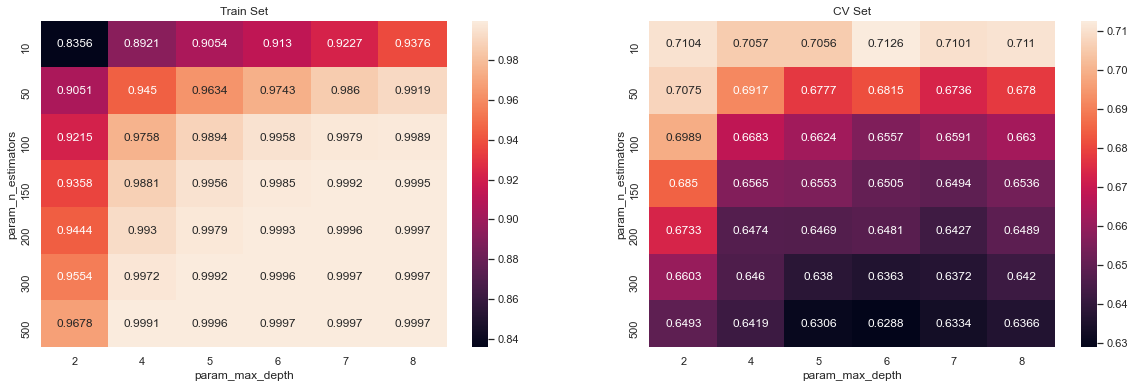

In [67]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show() 

In [68]:
# Print params
print(clf.best_estimator_)
print(clf.score(X_tr_svd, Y_train))
print(clf.score(X_te_svd, Y_test))

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
0.9006855870121283
0.841984911503628


In [75]:
def batch_predict(clf, data):
   

    data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
   
    for i in range(0, tr_loop, 1000):
        data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
   
    data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return data_pred

### 3.3 ROC curve

[11:19:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:19:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


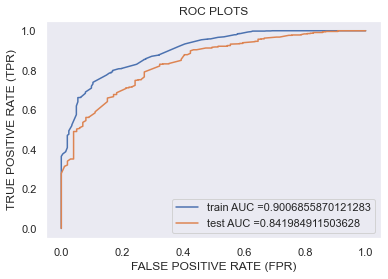

In [89]:
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

gbdt = xgb.XGBClassifier(max_depth = 6, n_estimators = 10,n_jobs=-1,class_weight='balanced')
gbdt.fit(X_tr_svd, Y_train)

y_train_pred = clf.predict_proba(X_tr_svd)[:,1]
y_test_pred = clf.predict_proba(X_te_svd)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE (FPR)")
plt.ylabel("TRUE POSITIVE RATE (TPR)")
plt.title("ROC PLOTS")
plt.grid()
plt.show()


#### observation
1.Model perform good on train data than test data

In [85]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]

    
    #(tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)    
    return predictions

In [60]:
def myplot_matrix1(data):
    plt.clf()
    plt.imshow(data, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Approved not approved matrix')
    tick_marks = np.arange(len(classNames))
    
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FN'], ['FP', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
    plt.show()

### 3.4 confusion matrix

In [90]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_bow=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_bow)
print("="*100)


Train confusion matrix
[[168  34]
 [229 909]]
Accuracy score  for Train
0.8037313432835821
Test confusion matrix
[[ 75  24]
 [151 410]]
Accuracy score  for Test
0.7348484848484849


confusion matrix for train data


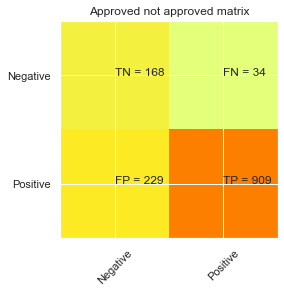

confusion matrix for Test data


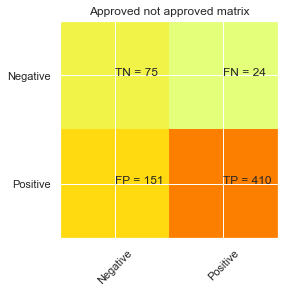

In [91]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

## 4.Model Performance Table

In [92]:
from prettytable import PrettyTable
x = PrettyTable()

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]
x.add_row(["AVG W2V", "XGBoost", "Max Depth:6 , n_estimators:10", 0.84])

print(x)

+------------+---------+-------------------------------+------+
| Vectorizer |  Model  |        Hyper Parameter        | AUC  |
+------------+---------+-------------------------------+------+
|  AVG W2V   | XGBoost | Max Depth:6 , n_estimators:10 | 0.84 |
+------------+---------+-------------------------------+------+


## 5.Observation

1.Using svd we get 84% accuracy in test data

2.True postive number in confusion matrix is good for test data
